In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import random

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
#from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.listdir('../input')

['melanoma-image',
 'evaluation-images',
 'skin-cancer-malignant-vs-benign',
 'jpeg-melanoma-128x128',
 'melanoma']

In [4]:
path = os.path.join("../input", 'jpeg-melanoma-128x128')
print(path)

../input/jpeg-melanoma-128x128


In [5]:
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [6]:
train = pd.read_csv('../input/jpeg-melanoma-128x128/train.csv')
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  tfrecord  width  height  
0   unknown           benign       0         0   6000    4000  
1   unknown           benign       0         0   6000    4000  
2     nevus           benign       0         6   1872    1053  
3   unknown           benign       0         0   1872    1053  
4   unknown           benign       0        11   6000    4000

In [7]:
test = pd.read_csv('../input/jpeg-melanoma-128x128/test.csv')
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0052060  IP_3579794    male        70.0                           NaN   
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity   
2  ISIC_0058510  IP_7960270  female        55.0                         torso   
3  ISIC_0073313  IP_6375035  female        50.0                         torso   
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity   

   width  height  
0   6000    4000  
1   6000    4000  
2   6000    4000  
3   6000    4000  
4   1920    1080

In [8]:
train.index

RangeIndex(start=0, stop=33126, step=1)

In [9]:
print(train.loc[train['image_name'] == 'ISIC_0068279'].index)

Int64Index([3], dtype='int64')


In [10]:
arr =[] 
arr.append(train['target'][train.loc[train['image_name'] == 'ISIC_0068279'].index])
print(arr[0] +1)

3    1
Name: target, dtype: int64


In [11]:
train['image_name'][0]

'ISIC_2637011'

In [12]:
len(train['image_name'])

33126

In [13]:
path = "../input/jpeg-melanoma-128x128/"
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

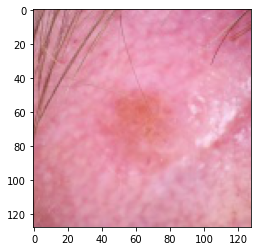

In [14]:
img = plt.imread(os.path.join(path, 'train', train['image_name'][0] + '.jpg'))
#img = cv2.resize(img, (128,128))
plt.imshow(img)

In [15]:
img.shape

(128, 128, 3)

In [16]:
def prepare_arrays (path) :
    images_data = []
    labels_data = []
    train = pd.read_csv(os.path.join(path, 'train.csv'))
    for k in tqdm(range(len(train['image_name']))) :
        img = plt.imread(os.path.join(path, 'train', train['image_name'][k] + '.jpg'))
        #img = cv2.resize(img, (128,128))
        images_data.append(img)
        labels_data.append(train['target'][k])
        
    print("finished : ", len(images_data))
    return images_data, labels_data

In [17]:
images_data, labels_data = prepare_arrays(path)

100%|██████████| 33126/33126 [01:53<00:00, 292.23it/s]

finished :  33126


In [18]:
#train['target'].value_counts 
len(train.loc[train['target'] == 1])

584

In [19]:
os.listdir('../input/skin-cancer-malignant-vs-benign')

['data', 'test', 'train']

In [20]:
def prepare_arrays2 (path) :
    data_labels = []
    data_images = []

    for i in tqdm(os.listdir(os.path.join(path, "train"))) :
        for j in (os.listdir(os.path.join(os.path.join(path, "train"), i))) :
            img = plt.imread(os.path.join(os.path.join(path, "train"), i, j))
            data_images.append(img)
            if (i == 'benign' ) : data_labels.append(0)
            else : data_labels.append(1)
                
    for i in tqdm(os.listdir(os.path.join(path, "test"))) :
        for j in (os.listdir(os.path.join(os.path.join(path, "test"), i))) :
            img = plt.imread(os.path.join(os.path.join(path, "test"), i, j))
            data_images.append(img)
            if (i == 'benign' ) : data_labels.append(0)
            else : data_labels.append(1)
            
    return data_images, data_labels

In [21]:
images_data2, labels_data2 = prepare_arrays2('../input/skin-cancer-malignant-vs-benign')

100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


In [22]:
os.listdir('../input/melanoma/DermMel')

['valid', 'test', 'train_sep']

In [23]:
os.listdir('../input/melanoma/dermmel/DermMel')

['valid', 'test', 'train_sep']

In [24]:
def prepare_arrays3 (path) :
    data_labels = []
    data_images = []

    for i in (os.listdir(os.path.join(path, "train_sep"))) :
        for j in tqdm(os.listdir(os.path.join(os.path.join(path, "train_sep"), i))) :
            img = plt.imread(os.path.join(os.path.join(path, "train_sep"), i, j))
            data_images.append(img)
            if (i == 'NotMelanoma' ) : data_labels.append(0)
            else : data_labels.append(1)
                
    for i in (os.listdir(os.path.join(path, "test"))) :
        for j in tqdm(os.listdir(os.path.join(os.path.join(path, "test"), i))) :
            img = plt.imread(os.path.join(os.path.join(path, "test"), i, j))
            data_images.append(img)
            if (i == 'NotMelanoma' ) : data_labels.append(0)
            else : data_labels.append(1)
                
    for i in (os.listdir(os.path.join(path, "valid"))) :
        for j in tqdm(os.listdir(os.path.join(os.path.join(path, "valid"), i))) :
            img = plt.imread(os.path.join(os.path.join(path, "valid"), i, j))
            data_images.append(img)
            if (i == 'NotMelanoma' ) : data_labels.append(0)
            else : data_labels.append(1)
            
    return data_images,data_labels

In [25]:
images_data3, labels_data3 = prepare_arrays3('../input/melanoma/DermMel')

100%|██████████| 1781/1781 [00:28<00:00, 61.78it/s]


In [26]:
print(len(images_data))
print(len(labels_data))

33126
33126


In [27]:
print(len(images_data2))
print(len(labels_data2))

3297
3297


In [28]:
print(len(images_data3))
print(len(labels_data3))

17805
17805


# Merging the three datasets

In [29]:
all_images = images_data + images_data2 + images_data3
all_labels = labels_data + labels_data2 + labels_data3
print(len(all_images))
print(len(all_labels))

54228
54228


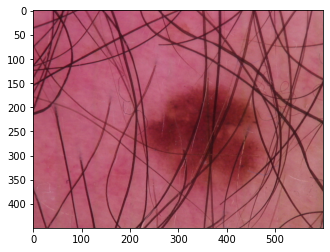

In [30]:
plt.imshow(all_images[54227])

[[[225 180 187]
  [225 180 187]
  [225 180 187]
  ...
  [228 183 186]
  [227 181 184]
  [229 183 185]]

 [[226 181 188]
  [226 181 188]
  [227 182 189]
  ...
  [228 183 188]
  [225 180 183]
  [231 185 188]]

 [[226 183 192]
  [227 184 193]
  [228 185 194]
  ...
  [228 183 188]
  [225 180 185]
  [229 184 187]]

 ...

 [[212 171 179]
  [214 172 182]
  [213 171 181]
  ...
  [223 182 190]
  [225 184 192]
  [226 185 193]]

 [[213 170 179]
  [212 171 179]
  [213 171 181]
  ...
  [223 182 190]
  [224 183 191]
  [222 181 189]]

 [[212 169 178]
  [209 166 175]
  [212 171 179]
  ...
  [222 181 189]
  [221 180 188]
  [216 175 183]]]


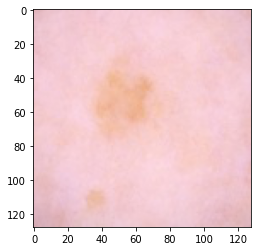

In [31]:
plt.imshow(all_images[30000])
print(all_images[30000])

In [32]:
len(all_images)
#print(labels_data[0])

54228

In [33]:
images = all_images.copy()
labels = all_labels.copy()

In [34]:
def plot_samples (images, labels) :
    real_labels = ["benign", "malignant"]
    fig = plt.figure(figsize = (20,25))
    rand = random.randint(0, len(images))

    for i in range(20): 
        fig.add_subplot(5,4, i+1)
        plt.title(real_labels[int(labels[rand])])
        plt.imshow(images[rand])
        rand = random.randint(0, len(images))

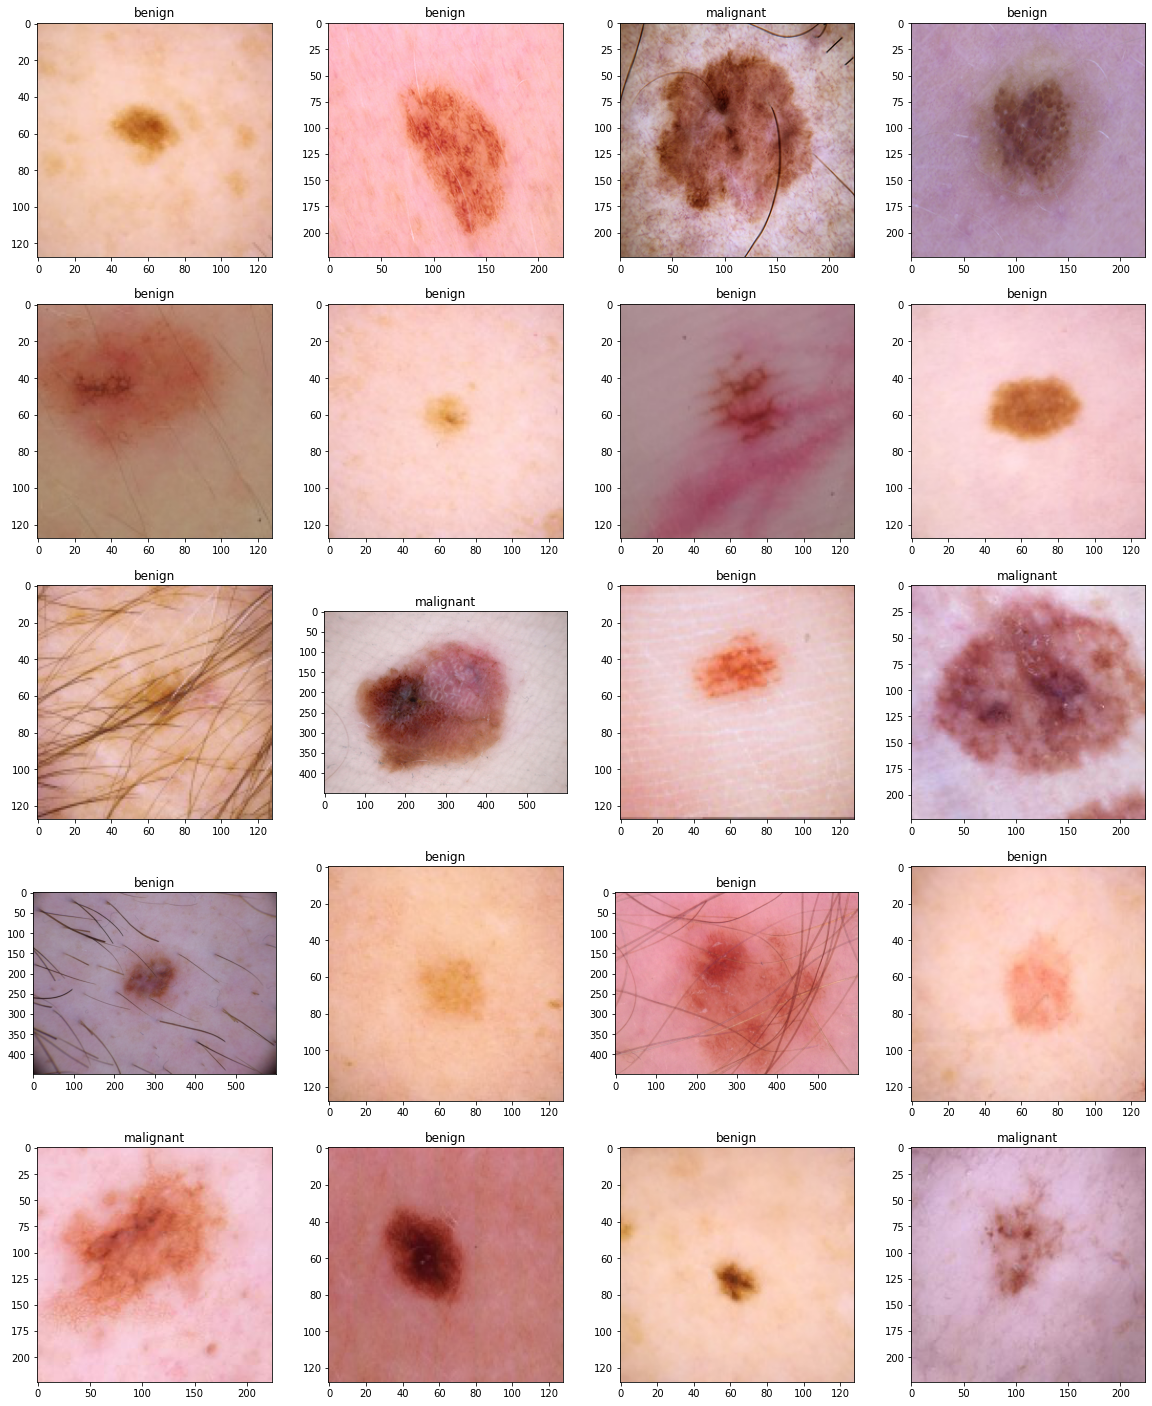

In [35]:
plot_samples(images, labels)

# processing the data for the model

In [36]:
def resize_array(images, size) :
    for i in range(len(images)) :
        images[i] = cv2.resize(images[i], size)
    return images

In [37]:
le = LabelEncoder()
def preprocess_data(images, labels) :
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    images, labels = shuffle(images, labels, random_state = 32)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 32)
    x_train = np.array(x_train) 
    x_test = np.array(x_test) 
    y_train = np.array(y_train) 
    y_test = np.array(y_test)
    return x_train, x_test, y_train, y_test

In [38]:
images = resize_array(images, tuple((32,32)))
x_train, x_test, y_train, y_test = preprocess_data(images, labels)

# modeling

# oversamping our data

In [39]:
images_arr = np.array(images)
print(images_arr.shape)
reshaped_images = images_arr.reshape(images_arr.shape[0], -1)
print(reshaped_images.shape)

oversample = RandomOverSampler()
oversample_images_non_normal, oversample_labels = oversample.fit_resample(reshaped_images, labels)

oversample_images = oversample_images_non_normal.reshape(-1, 32,32,3)
print(oversample_images.shape)

(54228, 32, 32, 3)
(54228, 3072)
(86488, 32, 32, 3)


In [40]:
c = 0
for i in oversample_labels :
    if i == 1:
        c += 1
        
print(c)

43244


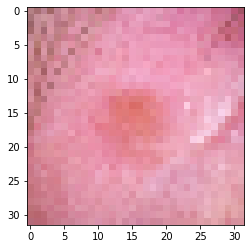

In [41]:
plt.imshow(oversample_images[0])

# New models

In [42]:
def build_model () :
    model = Sequential()
    model.add(Conv2D(filters = 128, kernel_size = (4,4), input_shape = (32, 32, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (4,4)))
    model.add(Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    #model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'sigmoid')) # sigmoid is better for binary classification

    model.summary()
    return model

In [43]:
def train(model, epochs_num) :
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)
    hist = model.fit(x_train, y_train, epochs = epochs_num, validation_data = (x_test, y_test))#, callbacks = early_stop)

In [44]:
x_train, x_test, y_train, y_test = preprocess_data(oversample_images, oversample_labels)
model = build_model()
train(model, 12)

2022-03-11 09:44:16.241447: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 128)       6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

2022-03-11 09:44:16.694376: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
2028/2028 [==============================] - 46s 22ms/step - loss: 0.3672 - accuracy: 0.8426 - val_loss: 0.5285 - val_accuracy: 0.7515
Epoch 2/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.3225 - accuracy: 0.8642 - val_loss: 0.5764 - val_accuracy: 0.7812
Epoch 3/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.2944 - accuracy: 0.8777 - val_loss: 0.3449 - val_accuracy: 0.8567
Epoch 4/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.2848 - accuracy: 0.8828 - val_loss: 0.8841 - val_accuracy: 0.6796
Epoch 5/12
2028/2028 [==============================] - 44s 22ms/step - loss: 0.2776 - accuracy: 0.8857 - val_loss: 0.9003 - val_accuracy: 0.7318
Epoch 6/12
2028/2028 [==============================] - 44s 22ms/step - loss: 0.2626 - accuracy: 0.8916 - val_loss: 0.3234 - val_accuracy: 0.8644
Epoch 7/12
2028/2028 [==============================] - 46s 23ms/step - loss: 0.2513 - accuracy: 0.8968 - val_loss: 0.8062 -

In [45]:
train(model, 12)

Epoch 1/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.2047 - accuracy: 0.9171 - val_loss: 0.4264 - val_accuracy: 0.8400
Epoch 2/12
2028/2028 [==============================] - 46s 23ms/step - loss: 0.1979 - accuracy: 0.9206 - val_loss: 0.4680 - val_accuracy: 0.8644
Epoch 3/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.1909 - accuracy: 0.9235 - val_loss: 0.2123 - val_accuracy: 0.9168
Epoch 4/12
2028/2028 [==============================] - 46s 23ms/step - loss: 0.1826 - accuracy: 0.9263 - val_loss: 0.2155 - val_accuracy: 0.9244
Epoch 5/12
2028/2028 [==============================] - 47s 23ms/step - loss: 0.2204 - accuracy: 0.9098 - val_loss: 0.2736 - val_accuracy: 0.8840
Epoch 6/12
2028/2028 [==============================] - 45s 22ms/step - loss: 0.1958 - accuracy: 0.9209 - val_loss: 0.3039 - val_accuracy: 0.8730
Epoch 7/12
2028/2028 [==============================] - 46s 23ms/step - loss: 0.1969 - accuracy: 0.9208 - val_loss: 0.3488 -

In [46]:
def plot_scores (model) :
    scores = pd.DataFrame(model.history.history)
    titles = ["accuaracy vs val_accuracy", "loss vs val_loss"]
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (24,6))
    #fig, ax = plt.figure(figsize = (20,8))

    for i in range(2): 
        fig.add_subplot(1,2, i+1)
        axes[i].set_title(titles[i])
        if i==0 : plt.plot(scores[['accuracy','val_accuracy']])#, color = 'green')
        if i==1 : plt.plot(scores[['loss','val_loss']])#, color = 'green')
        #scores[['accuracy', 'val_accuracy']].plot(ax = axes[i])

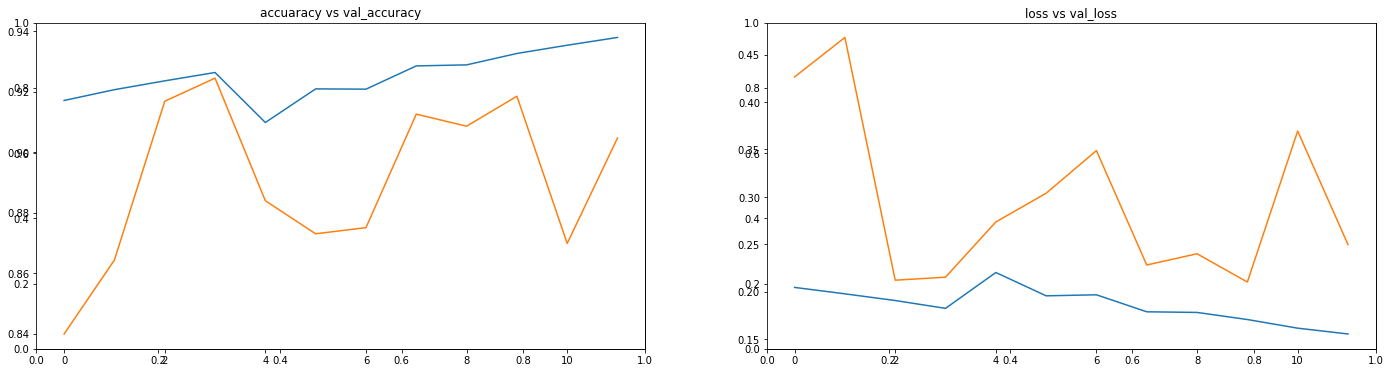

In [47]:
plot_scores(model) 

In [48]:
pred = np.argmax(model.predict(x_test), axis = -1)
y_testc = np.argmax(y_test, axis = -1)

print(classification_report(y_testc, pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     10885
           1       0.86      0.97      0.91     10737

    accuracy                           0.90     21622
   macro avg       0.91      0.91      0.90     21622
weighted avg       0.91      0.90      0.90     21622



In [49]:
model.save('Normal_skin_cancer_model3.h5')

# oversampling with augmentation

In [50]:
#be calm and watch wa3i
def image_augmentation(x_train, x_test, y_train, y_test) :
    image_generator = ImageDataGenerator(
        rescale = 1/255.
    )
    train_generator = image_generator.flow(x_train, y_train, batch_size = 32)
    test_generator = image_generator.flow(x_test, y_test, batch_size = 32)
    return train_generator, test_generator

In [51]:
def trainA(model, epochs_num) :
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)
    hist = model.fit(train_generator, epochs = epochs_num, validation_data = (test_generator))#, callbacks = early_stop)

In [52]:
train_generator, test_generator = image_augmentation(x_train, x_test, y_train, y_test)
modelA = build_model()
trainA(modelA, 24)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 29, 29, 128)       6272      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

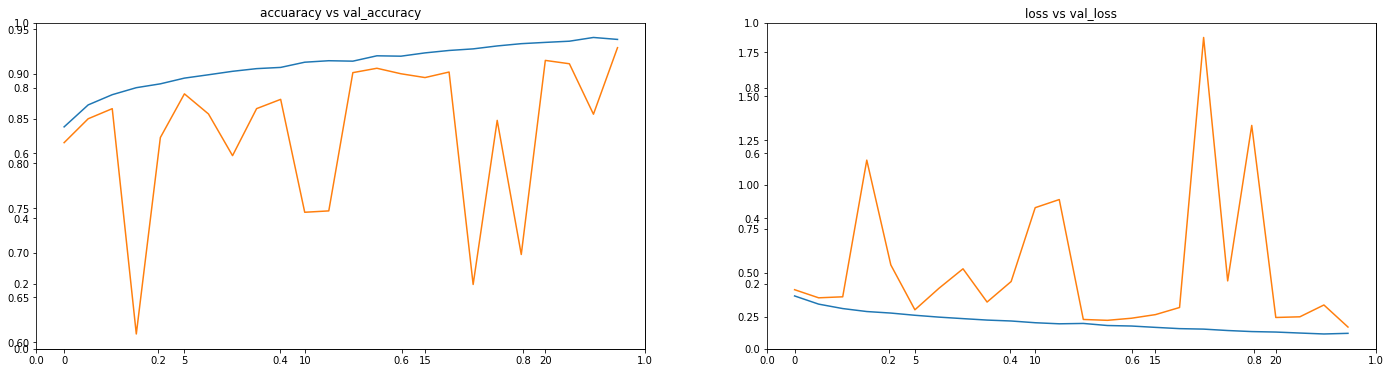

In [53]:
plot_scores(modelA) 

In [54]:
modelA.evaluate(train_generator)
modelA.evaluate(test_generator)

676/676 [==============================] - 5s 7ms/step - loss: 0.1920 - accuracy: 0.9293


[0.19204400479793549, 0.9293312430381775]

In [55]:
predA = np.argmax(modelA.predict(x_test), axis = -1)
y_testc = np.argmax(y_test, axis = -1)


print(len(x_test))
print(len(y_test))
print(accuracy_score(y_testc, predA))
print(classification_report(y_testc, predA))

21622
21622
0.5079548607899361
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     10885
           1       0.95      0.01      0.02     10737

    accuracy                           0.51     21622
   macro avg       0.73      0.50      0.35     21622
weighted avg       0.73      0.51      0.35     21622



In [56]:
modelA.save('Augmented_skin_cancer_model.h5')

# evaluation

In [57]:
def prepare_eval_array (path) :
    eval_array = []
    train = pd.read_csv(os.path.join(path, 'train.csv'))
    for k in tqdm(range(10)) :
        rand = random.randint(0, len(test['image_name']))
        try :
            img = plt.imread(os.path.join(path, 'test', test['image_name'][rand] + '.jpg'))
            img = cv2.resize(img, (128,128))
            eval_array.append(img)
        except :
            continue
    print("finished : ", len(eval_array))
    return eval_array

In [58]:
eval_array = prepare_eval_array(path)

100%|██████████| 10/10 [00:00<00:00, 217.85it/s]

finished :  10


In [59]:
def plot_predictions (model) :
    fig = plt.figure(figsize = (20,8))
    real_labels = ["benign", "malignant"]

    for i in range(10) :
        img = eval_array[i]
        img = cv2.resize(img, (32,32))
        img = img.reshape(1,32,32,3)
        val = np.argmax(model.predict(img))
        fig.add_subplot(2,5, i+1)
        plt.title(real_labels[val])
        plt.imshow(eval_array[i])

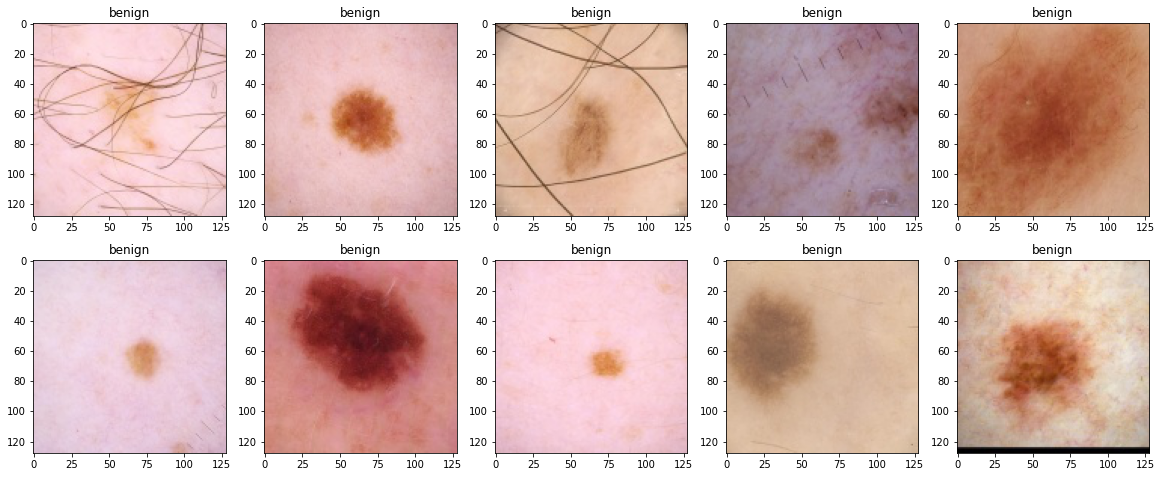

In [60]:
plot_predictions(model)

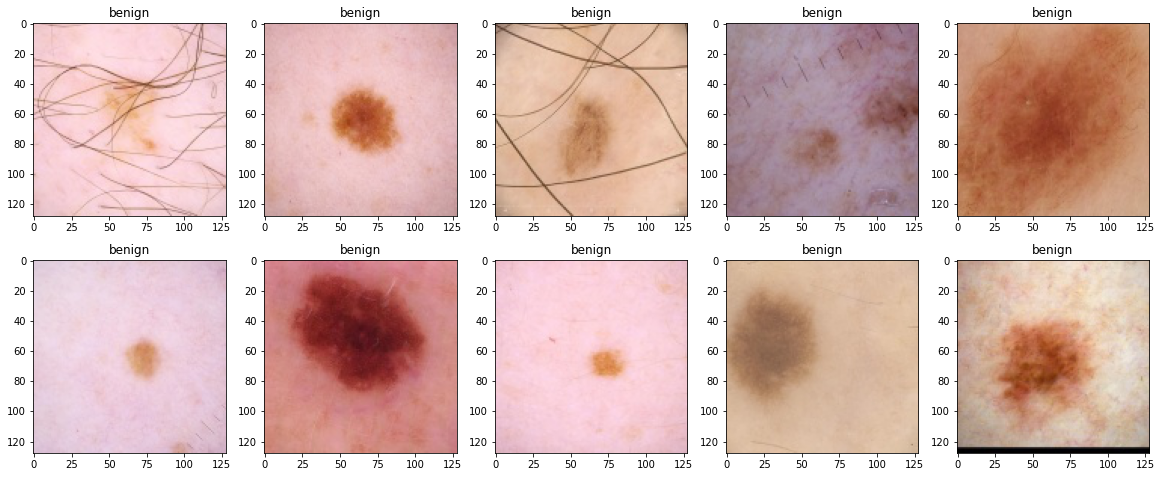

In [61]:
plot_predictions(modelA)

# images from website

In [62]:
os.listdir("../input")

['melanoma-image',
 'evaluation-images',
 'skin-cancer-malignant-vs-benign',
 'jpeg-melanoma-128x128',
 'melanoma']

In [63]:
os.listdir("../input/evaluation-images")

['malignant_skin2.jpg', 'binign_skin1.jpg', 'malignant_skin1.jpg']

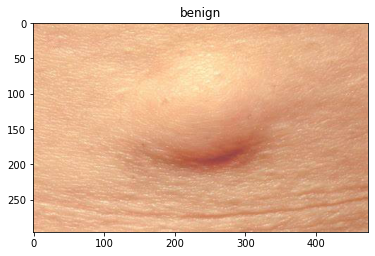

In [64]:
real_labels = ["benign", "malignant"]
img = plt.imread("../input/evaluation-images/binign_skin1.jpg")
img1 = img.copy()
img1 = cv2.resize(img1, (32,32))
img1 = img1.reshape(1,32,32,3)
val = np.argmax(model.predict(img1))
plt.title(real_labels[val])
plt.imshow(img)

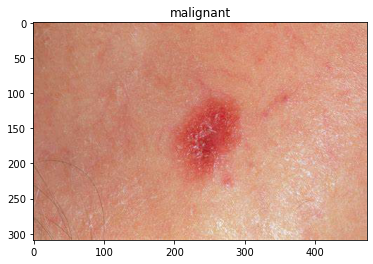

In [65]:
real_labels = ["benign", "malignant"]
img = plt.imread("../input/evaluation-images/malignant_skin1.jpg")
img1 = img.copy()
img1 = cv2.resize(img1, (32,32))
img1 = img1.reshape(1,32,32,3)
val = np.argmax(model.predict(img1))
plt.title(real_labels[val])
plt.imshow(img)

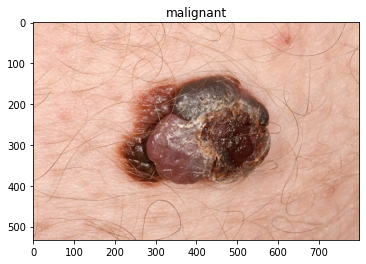

In [66]:
real_labels = ["benign", "malignant"]
img = plt.imread("../input/evaluation-images/malignant_skin2.jpg")
img1 = img.copy()
img1 = cv2.resize(img1, (32,32))
img1 = img1.reshape(1,32,32,3)
val = np.argmax(model.predict(img1))
plt.title(real_labels[val])
plt.imshow(img)

In [67]:
os.listdir("../input/melanoma-image")

['melanoma-14.jpg']

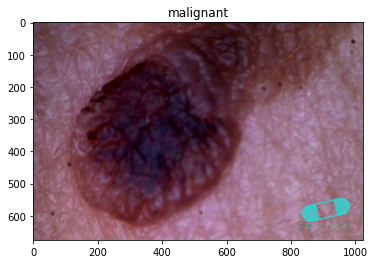

In [68]:
real_labels = ["benign", "malignant"]
img = plt.imread("../input/melanoma-image/melanoma-14.jpg")
img1 = img.copy()
img1 = cv2.resize(img1, (32,32))
img1 = img1.reshape(1,32,32,3)
val = np.argmax(model.predict(img1))
plt.title(real_labels[val])
plt.imshow(img)

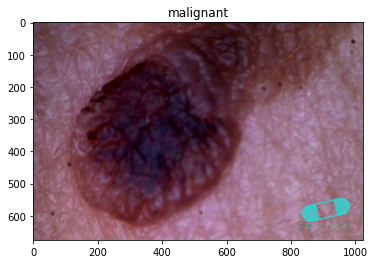

In [69]:
real_labels = ["benign", "malignant"]
img = plt.imread("../input/melanoma-image/melanoma-14.jpg")
img1 = img.copy()
img1 = cv2.resize(img1, (32,32))
img1 = img1.reshape(1,32,32,3)
val = np.argmax(modelA.predict(img1))
plt.title(real_labels[val])
plt.imshow(img)